**cml1 - Immobilienrechner**

# 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.

## Module importieren

In [642]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# ensemble models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# xgb model
import xgboost as xgb
from xgboost import XGBRegressor

# imputing
from sklearn.impute import KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# pipeline
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# save model
import pickle

## Daten laden

Damit die Predictions die korrekten IDs haben, müssen die rohe Kaggle-Daten geladen werden und die IDs extrahiert werden. Diese werden wir später wieder benötigen.

In [643]:
df_raw_kaggle = pd.read_csv('../../../data/test_data-Kaggle-v0.11.csv', low_memory=False)

# get indexes for predictions
indexes = df_raw_kaggle["Unnamed: 0"]

In [644]:
df = pd.read_csv('../../../data/immo_data_clean.csv', low_memory=False)
df_kaggle = pd.read_csv('../../../data/test_data_kaggle_clean.csv', low_memory=False)

Hinweis: `Floor_space_merged` wurde bereits automatisch im datawrangling_kaggle Notebook gelöscht. Darum müssen wir diese Variable hier nicht eingeben.

In [645]:
df = df.drop(columns=[
	"Zip",
	"Availability_Categorized",
    "type_unified",
    "Floor_space_merged",

    "gde_politics_bdp",
    "gde_politics_cvp",
    "gde_politics_evp",
    "gde_politics_fdp",
    "gde_politics_glp",
    "gde_politics_gps",
    "gde_politics_pda",
    "gde_politics_rights",
    "gde_politics_sp",
    "gde_politics_svp",

    "gde_workers_sector1",
    "gde_workers_sector2",
    "gde_workers_sector3",

    "distanceToTrainStation",

    "NoisePollutionRailwayL", "NoisePollutionRailwayM", "NoisePollutionRailwayS", 
    "NoisePollutionRoadL", "NoisePollutionRoadM", "NoisePollutionRoadS", 
    "PopulationDensityL", "PopulationDensityM", "PopulationDensityS", 
    "RiversAndLakesL", "RiversAndLakesM", "RiversAndLakesS", 
    "WorkplaceDensityL", "WorkplaceDensityM", "WorkplaceDensityS", 
    "ForestDensityL", "ForestDensityM", "ForestDensityS"
])

df_kaggle = df_kaggle.drop(columns=[
	"Zip",
	"Availability_Categorized",
    "type_unified",

    "gde_politics_bdp",
    "gde_politics_cvp",
    "gde_politics_evp",
    "gde_politics_fdp",
    "gde_politics_glp",
    "gde_politics_gps",
    "gde_politics_pda",
    "gde_politics_rights",
    "gde_politics_sp",
    "gde_politics_svp",

    "gde_workers_sector1",
    "gde_workers_sector2",
    "gde_workers_sector3",

    "distanceToTrainStation",

    "NoisePollutionRailwayL", "NoisePollutionRailwayM", "NoisePollutionRailwayS", 
    "NoisePollutionRoadL", "NoisePollutionRoadM", "NoisePollutionRoadS", 
    "PopulationDensityL", "PopulationDensityM", "PopulationDensityS", 
    "RiversAndLakesL", "RiversAndLakesM", "RiversAndLakesS", 
    "WorkplaceDensityL", "WorkplaceDensityM", "WorkplaceDensityS", 
    "ForestDensityL", "ForestDensityM", "ForestDensityS",
])

## Daten vorbereiten

In [646]:
def preprocess_dataframe(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    df_processed = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

    return df_processed, numerical_columns

df, num_cols_df = preprocess_dataframe(df)
df_kaggle, num_cols_df_kaggle = preprocess_dataframe(df_kaggle)

df = df[df['price_cleaned'] > 10000]

df = df.dropna(subset=['price_cleaned'], axis=0)

print("Dataset after removing rows with missing target values:")
print(df.shape)

print("Kaggle Test Dataset")
print(df_kaggle.shape)

Dataset after removing rows with missing target values:
(21444, 45)
Kaggle Test Dataset
(24556, 44)


In [647]:
columns_df1 = set(df.columns)
columns_df2 = set(df_kaggle.columns)

# Compare the sets of columns
if columns_df1 == columns_df2:
    print("The dataframes have the same column names.")
else:
    print("The dataframes do not have the same column names.")

    # Find out which columns are different
    diff_df1 = columns_df1 - columns_df2
    diff_df2 = columns_df2 - columns_df1

    if diff_df1:
        print("Columns in df1 not in df2:", diff_df1)
    if diff_df2:
        print("Columns in df2 not in df1 (dropped):", diff_df2)
        df_kaggle.drop(diff_df2, axis=1, inplace=True)

The dataframes do not have the same column names.
Columns in df1 not in df2: {'price_cleaned'}


## Train Test Split

Da wir für hier für den Kaggle-Contest einen Testdatensatz bekommen haben, werden wir die Daten wie folgt aufteilen:

1. Trainingsdaten (80%): Diese Daten werden verwendet, um das Modell zu trainieren.

2. Validierungsdaten (20%): Diese Daten werden verwendet, um die Leistung des Modells während des Trainings zu bewerten und Hyperparameter zu optimieren.

3. Testdaten (Kaggle Testdatensatz): Diese Daten werden separat gehalten und werden erst verwendet, nachdem das Modell trainiert und validiert wurde, um die Endleistung des Modells zu bewerten. Diese Testdaten sind repräsentativ für echte, unabhängige Daten und dienen dazu, die Generalisierungsfähigkeit des Modells zu überprüfen.

In [648]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop("price_cleaned", axis=1)
y_train = train["price_cleaned"]

X_val= val.drop("price_cleaned", axis=1)
y_val = val["price_cleaned"]

X_test_kaggle = df_kaggle

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test_kaggle shape: ", X_test_kaggle.shape)

X_train shape:  (17155, 44)
y_train shape:  (17155,)
X_val shape:  (4289, 44)
y_val shape:  (4289,)
X_test_kaggle shape:  (24556, 44)


In [649]:
# make sure that the columns are in the same order
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_val = X_val.reindex(sorted(X_val.columns), axis=1)
X_test_kaggle = X_test_kaggle.reindex(sorted(X_test_kaggle.columns), axis=1)

## Imputation

In [650]:
cols = X_train.columns

imputer = KNNImputer(n_neighbors=5)

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=cols)
X_test_kaggle_imputed = pd.DataFrame(imputer.fit_transform(df_kaggle), columns=cols)

## Standardisierung

Wir haben bemerkt, dass die Datensätze mit fehlenden Werten keine gute Vorhersagen auf dem Kaggle-Testdatensatz liefern. Deshalb haben wir uns entschieden, die Datensätze mit fehlenden Werten hier nicht mehr zu berücksichtigen.

In [654]:
scaler = StandardScaler()

scaler = scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
X_val = pd.DataFrame(scaler.transform(X_val), columns=cols)
X_test_kaggle = pd.DataFrame(scaler.transform(X_test_kaggle), columns=cols)

## Modelle

### Modell 5: XGBoost (Log-Transformiert)

In [655]:
def xgb_model(
        X_train,
        y_train,
        X_test,
        y_test,
        cv,
        max_depth,
        learning_rate,
        min_split_loss,
        reg_lambda,
        booster
    ):

    xgb = XGBRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'min_split_loss': min_split_loss,
        'reg_lambda': reg_lambda,
        'booster': booster,
        'random_state': [42]
    }

    grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_xgb.fit(X_train, np.log(y_train))

    best_params = grid_xgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_xgb = grid_xgb.predict(X_test)
    y_pred_xgb = np.exp(y_pred_xgb)

    y_pred_xgb2 = grid_xgb.predict(X_train)
    y_pred_xgb2 = np.exp(y_pred_xgb2)

    mape_xgb = round(mean_absolute_percentage_error(y_test, y_pred_xgb), 4)
    print('MAPE test: {}'.format(mape_xgb))

    mape_xgb2 = round(mean_absolute_percentage_error(y_train, y_pred_xgb2), 4)
    print('MAPE train: {}'.format(mape_xgb2))

    r2_xgb = round(r2_score(y_test, y_pred_xgb), 4)
    print('R2: {}'.format(r2_xgb))

    return grid_xgb, mape_xgb

xgb_regression_log, mape_xgb_log = xgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    max_depth = [6],
    learning_rate = [0.1],
    min_split_loss = [0.05],
    reg_lambda = [4],
    booster = ['gbtree']
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'min_split_loss': 0.05, 'random_state': 42, 'reg_lambda': 4}
MAPE test: 0.2699
MAPE train: 0.2147
R2: 0.6972


In [656]:
xgb_best = xgb_regression_log.best_estimator_

#### Extreme Gradient Boosting Regression Predictions

In [279]:
# Making predictions on the test set
y_pred_xgb_best = xgb_best.predict(X_test_kaggle)
y_pred_xgb_best = np.exp(y_pred_xgb_best)

predictions = pd.DataFrame({"ID": indexes, "Expected": y_pred_xgb_best})
predictions.to_csv('../../99_gespeicherte_modelle/predictions_xgb_log_best_mape_train_test_difference.csv', index=False)

### Modell 9: Hist Gradient Boosting Regression (Log-Transformiert)

In [390]:
def hgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv, 
        loss,
        learning_rate, 
        max_iter,
        max_leaf_nodes,
        max_depth, 
        l2_regularization, 
        random_state,
    ):
    
    hgb = HistGradientBoostingRegressor()

    param_grid = {
        'loss': loss,
        'learning_rate': learning_rate,
        'max_iter': max_iter,
        'max_leaf_nodes': max_leaf_nodes,
        'max_depth': max_depth,
        'l2_regularization': l2_regularization,
        'random_state': random_state
    }

    grid_hgb = GridSearchCV(hgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_hgb.fit(X_train, np.log(y_train))

    best_params = grid_hgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_hgb = grid_hgb.predict(X_test)
    y_pred_hgb = np.exp(y_pred_hgb)
    y_pred_hgb2 = grid_hgb.predict(X_train)
    y_pred_hgb2 = np.exp(y_pred_hgb2)

    mape_hgb = round(mean_absolute_percentage_error(y_test, y_pred_hgb), 4)
    print('MAPE test: {}'.format(mape_hgb))
    mape_hgb2 = round(mean_absolute_percentage_error(y_train, y_pred_hgb2), 4)
    print('MAPE train: {}'.format(mape_hgb2))

    r2_hgb = round(r2_score(y_test, y_pred_hgb), 4)
    print('R2: {}'.format(r2_hgb))

    return grid_hgb, mape_hgb

hgb_regression_log, mape_hgb_log = hgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    loss = ['gamma'],
    learning_rate = [0.01, 0.1, 0.2, 0.3],
    max_iter = [500, 1000, 2000, 3000],
    max_leaf_nodes = [12, 23, 31, 50, 70, 100],
    max_depth = [None],
    l2_regularization = [0.1, 0.2, 0.01, 0.1],
    random_state = [42]
)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'loss': 'gamma', 'max_depth': None, 'max_iter': 500, 'max_leaf_nodes': 100, 'random_state': 42}
MAPE test: 0.2484
MAPE train: 0.1388
R2: 0.7


In [657]:
hgb_regression_log_simple, mape_hgb_log = hgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    loss = ['gamma'],
    learning_rate = [0.1],
    max_iter = [500],
    max_leaf_nodes = [21],
    max_depth = [6],
    l2_regularization = [0.2],
    random_state = [42]
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'l2_regularization': 0.2, 'learning_rate': 0.1, 'loss': 'gamma', 'max_depth': 6, 'max_iter': 500, 'max_leaf_nodes': 21, 'random_state': 42}
MAPE test: 0.2558
MAPE train: 0.1857
R2: 0.7023


In [658]:
hgb_best = hgb_regression_log_simple.best_estimator_

#### Hist Gradient Boosting Regression Predictions

In [641]:
# Making predictions on the test set
y_pred_hgb_best = hgb_best.predict(X_test_kaggle)
y_pred_hgb_best = np.exp(y_pred_hgb_best)

predictions = pd.DataFrame({"ID": indexes, "Expected": y_pred_hgb_best})
predictions.to_csv('../../99_gespeicherte_modelle/predictions_hgb_log.csv', index=False)

## Kombinieren der Modelle

In [510]:
# Predict on both models
y_pred_val_hgb = np.exp(hgb_best.predict(X_val))
y_pred_val_xgb = np.exp(xgb_best.predict(X_val))

# Calculate errors for the validation set
errors_hgb = np.abs(y_val - y_pred_val_hgb)
errors_xgb = np.abs(y_val - y_pred_val_xgb)

# Create a new feature 
X_val_with_errors = np.column_stack((X_val, errors_hgb, errors_xgb))

Der angereicherte Feature `X_val_with_errors` kombiniert die ursprünglichen Daten mit Metamerkmalen (Errors unserer Modelle), die zusätzliche Informationen für die nächste Stufe der Modellierung liefern.

Ein neuer HistGradientBoostingRegressor (Metamodell) wird nun auf dieser erweiterten Validierungsmenge (X_val_with_errors) unter Verwendung der ursprünglichen Zielwerte (y_val) trainiert. Das Metamodell lernt also, die Zielvariable nicht nur auf der Grundlage der ursprünglichen Merkmale vorherzusagen, sondern berücksichtigt auch, wie jedes der vorherigen Modelle (HGB und XGB) in Bezug auf Fehler abgeschnitten hat.

In [511]:
params = {
    'loss': 'gamma',
    'learning_rate': 0.1,
    'max_iter': 300,
    'max_leaf_nodes': 31,
    'max_depth': 6,
    'random_state': 42
}

# Train a Meta-Model
meta_model = HistGradientBoostingRegressor(**params)
meta_model.fit(X_val_with_errors, y_val)

# Apply to Kaggle Test Set and Predict
# Predict on the Kaggle Test Set using both models
y_pred_test_hgb = np.exp(hgb_best.predict(X_test_kaggle))
y_pred_test_xgb = np.exp(xgb_best.predict(X_test_kaggle))

# Calculate errors for the Kaggle Test Set
errors_hgb_kaggle = np.abs(y_pred_test_hgb - y_pred_test_xgb)

# Create a new feature set for the Kaggle Test Set
X_test_kaggle_with_errors = np.column_stack((X_test_kaggle, errors_hgb_kaggle, errors_hgb_kaggle))

# Predict using the Meta-Model
final_predictions = meta_model.predict(X_test_kaggle_with_errors)

In [512]:
predictions = pd.DataFrame({"ID": indexes, "Expected": final_predictions})
predictions.to_csv('../../99_gespeicherte_modelle/predictions_combined_v4.csv', index=False)

## Vorhersagen von den besten Modellen

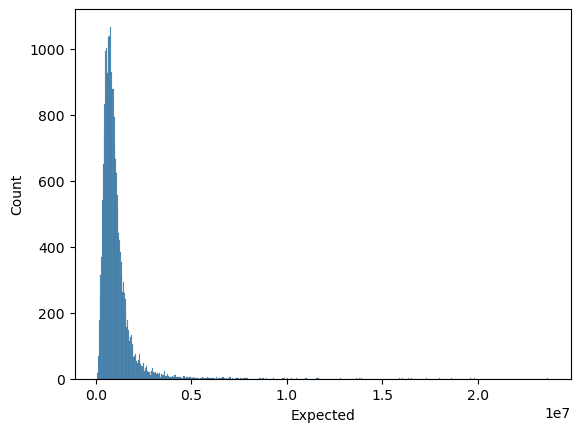

82717.71656606915
23696750.155614503


In [509]:
pred_combined = pd.read_csv('../../99_gespeicherte_modelle/predictions_combined_v4.csv')
pred_combined = pred_combined["Expected"]

sns.histplot(pred_combined)
plt.title("Predictions combined")
plt.show()

print(pred_combined.min())
print(pred_combined.max())

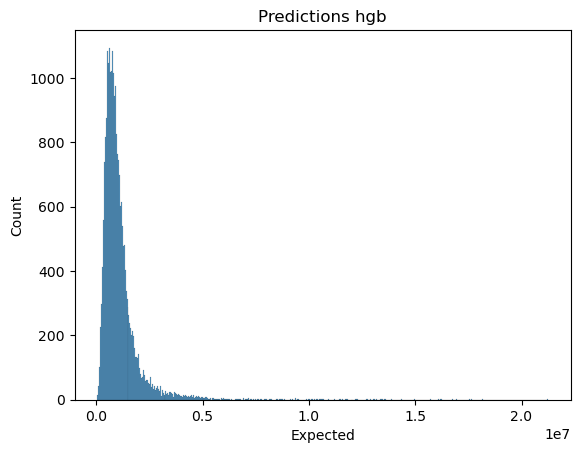

50447.75252810349
21255748.09038129
count       24556.00
mean      1104788.84
std       1033509.04
min         50447.75
25%        596887.93
50%        869606.43
75%       1263731.31
max      21255748.09
Name: Expected, dtype: float64


In [514]:
pred_best_hgb = pd.read_csv('../../99_gespeicherte_modelle/predictions_hgb_log_best.csv')
pred_best_hgb = pred_best_hgb["Expected"]

sns.histplot(pred_best_hgb)
plt.title("Predictions hgb")
plt.show()

print(pred_best_hgb.min())
print(pred_best_hgb.max())
print(round(pred_best_hgb.describe(),2))

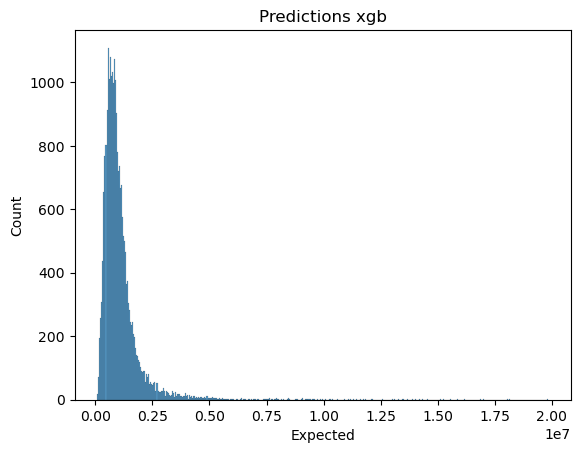

87153.67
19839594.0
count       24556.00
mean      1096318.55
std       1008094.30
min         87153.67
25%        605613.50
50%        868949.05
75%       1255838.10
max      19839594.00
Name: Expected, dtype: float64


In [515]:
pred_best_xgb = pd.read_csv('../../99_gespeicherte_modelle/predictions_xgb_log_best_mape_train_test_difference.csv')
pred_best_xgb = pred_best_xgb["Expected"]

sns.histplot(pred_best_xgb)
plt.title("Predictions xgb")
plt.show()

print(pred_best_xgb.min())
print(pred_best_xgb.max())
print(round(pred_best_xgb.describe(),2))

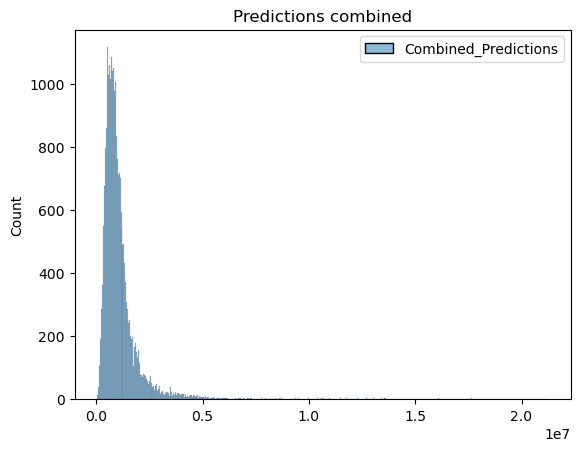

Combined_Predictions    50447.752528
dtype: float64
Combined_Predictions    2.125575e+07
dtype: float64


In [523]:
combined_predictions = []

# Iterate through the predictions and apply your conditions
for hgb_pred, xgb_pred in zip(pred_best_hgb, pred_best_xgb):
    if hgb_pred < 200000 or hgb_pred > 1800000:
        combined_predictions.append(hgb_pred)
    else:
        # mean of both predictions
        combined_predictions.append((hgb_pred + xgb_pred) / 2)

# Convert the combined predictions list to a DataFrame if needed
combined_predictions_df = pd.DataFrame(combined_predictions, columns=['Combined_Predictions'])

# plot the predictions
sns.histplot(combined_predictions_df)
plt.title("Predictions combined")
plt.show()

print(combined_predictions_df.min())
print(combined_predictions_df.max())

# save
predictions = pd.DataFrame({"ID": indexes, "Expected": combined_predictions_df["Combined_Predictions"]})
predictions.to_csv('../../99_gespeicherte_modelle/predictions_combined_v5.csv', index=False)